In [ ]:
# Uninstall any existing TensorFlow
!pip uninstall tensorflow -y

# Install TensorFlow 2.17
!pip install tensorflow==2.17.0

# Install Keras, Keras Tuner, and other required libraries
!pip install keras keras-tuner scikit-learn matplotlib scikit-image

# Verify the installation
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelBinarizer

print("TensorFlow version:", tf.__version__)
print("Keras Tuner version:", kt.__version__)



Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00
TensorFlow version: 2.17.0
Keras Tuner version: 1.4.7


In [ ]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization ,Activation, GlobalAveragePooling2D,LayerNormalization
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam, AdamW, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2,l1_l2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve
from google.colab import drive
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load images and labels
batch_size = 32
num_images = 2000

def load_images_and_labels(folder_path, image_size=(224, 224), num_samples=num_images):
    images = []
    labels = []

    # Load all images and labels
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            image = imread(file_path)
            if image is not None:
                image = resize(image, image_size, anti_aliasing=True)
                image = normalize_image(image)
                images.append(image)
                label = file.rsplit('_', 1)[0]
                labels.append(label)
        except Exception as e:
            print(f"Error loading {file}: {e}")

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Randomly select num_samples samples
    if len(images) > num_samples:
        indices = np.random.choice(len(images), num_samples, replace=False)
        images = images[indices]
        labels = labels[indices]

    # Return the numpy arrays
    return np.array(images), np.array(labels)



In [ ]:
def normalize_image(image):
    # Normalize the image to scale pixel values to [0, 1]
    return image / 255.0


In [ ]:
def standardize_images(images, mean, stddev):
    return (images - mean) / stddev


In [ ]:
# Load dataset
folder_path = '/content/drive/MyDrive/Colab Notebooks/Model/Data/Kagg/Val_Dataset'
val_images, val_labels = load_images_and_labels(folder_path)

# Check the shape of images and labels
print("Shape of images:", val_images.shape)
print("Shape of labels:", val_labels.shape)




Shape of images: (2000, 224, 224, 3)
Shape of labels: (2000,)


In [ ]:
#Load the train dataset computed mean and stddev
mean_np=np.load('/content/drive/MyDrive/Colab Notebooks/Model/mean.npy')
stddev_np=np.load('/content/drive/MyDrive/Colab Notebooks/Model/stddev.npy')

# Standardize images using computed mean and stddev
standardized_images_np = standardize_images(val_images, mean_np, stddev_np)


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
lbl_encoded = label_encoder.fit_transform(val_labels)

num_classes = len(label_encoder.classes_)

#Model Validation

In [ ]:
# Load the pre trained model
validation_model = load_model('/content/drive/MyDrive/Colab Notebooks/Model/BestModelwithCrossVal.keras')



In [ ]:
validation_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 256)                 │              

 Total params: 4,723,269 (18.02 MB)

 Trainable params: 1,573,889 (6.00 MB)

 Non-trainable params: 1,600 (6.25 KB)

 Optimizer params: 3,147,780 (12.01 MB)

In [ ]:
# Define batch size
batch_size = 32

# Predict probabilities
y_pred = validation_model.predict(standardized_images_np, batch_size=batch_size)

# Flatten the predictions and true labels
y_pred_flat = y_pred.flatten()
y_pred_classes = (y_pred_flat > 0.5).astype("int32")
true_labels = lbl_encoded.flatten()

# Generate classification report
report = classification_report(true_labels, y_pred_classes, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)

# Compute ROC AUC score
auc = roc_auc_score(true_labels, y_pred_flat)
print(f"ROC AUC Score: {auc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97       596
     Class 1       0.99      0.99      0.99      1404

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

ROC AUC Score: 0.9978


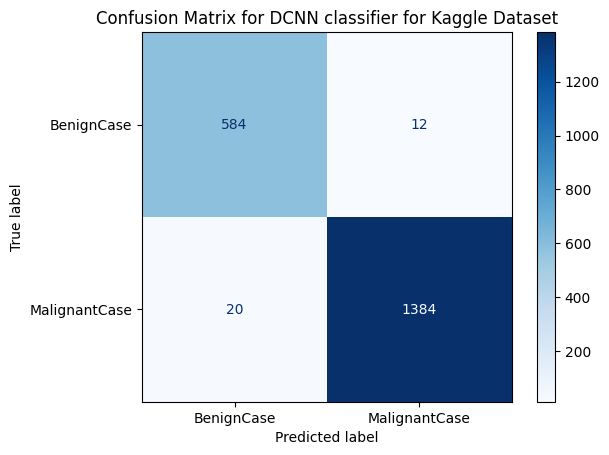

In [ ]:
# Compute confusion matrix
cm_Dcnn = confusion_matrix(true_labels, y_pred_classes)

# Display confusion matrix
disp_Dcnn = ConfusionMatrixDisplay(confusion_matrix=cm_Dcnn, display_labels=label_encoder.classes_)
disp_Dcnn.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for DCNN classifier for Kaggle Dataset')
plt.show()

# Saliency Map

In [ ]:
def compute_saliency_map(model, image_array, class_index):
    # Convert image_array to a TensorFlow tensor
    image_array = tf.convert_to_tensor(image_array, dtype=tf.float32)

    # Add batch dimension if not already present
    if len(image_array.shape) == 3:  # If shape is (height, width, channels)
        image_array = tf.expand_dims(image_array, axis=0)  # shape is (1, height, width, channels)

    with tf.GradientTape() as tape:
        tape.watch(image_array)
        predictions = model(image_array, training=False)  #  model is in inference mode
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, image_array)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)  # Reduce over color channels
    return saliency[0].numpy()  # Remove batch dimension and convert to NumPy array

def get_class_index(model, image_array):
    # Convert image_array to a TensorFlow tensor
    image_array = tf.convert_to_tensor(image_array, dtype=tf.float32)

    # Add batch dimension if not already present
    if len(image_array.shape) == 3:  # If shape is (height, width, channels)
        image_array = tf.expand_dims(image_array, axis=0)  # Now shape is (1, height, width, channels)

    predictions = model(image_array, training=False)  # model is in inference mode
    return np.argmax(predictions.numpy(), axis=1)[0]

In [ ]:
# Define batch size
batch_size = 32

# Predict probabilities
y_pred = validation_model.predict(standardized_images_np, batch_size=batch_size)

# Flatten the predictions and true labels
y_pred_flat = y_pred.flatten()
y_pred_classes = (y_pred_flat > 0.5).astype("int32")
true_labels = lbl_encoded.flatten()

# Determine whether each prediction is correct
correct_predictions = (y_pred_classes == true_labels)

# Separate predictions and labels into correct and incorrect groups
correct_indices = np.where(correct_predictions)[0]
incorrect_indices = np.where(~correct_predictions)[0]


In [ ]:

# Get the correct and incorrect images and their labels
correct_images = standardized_images_np[correct_indices]
incorrect_images = standardized_images_np[incorrect_indices]
correct_labels = true_labels[correct_indices]
incorrect_labels = true_labels[incorrect_indices]

# Separate by class
def separate_by_class(images, labels, class_index):
    class_indices = np.where(labels == class_index)[0]
    return images[class_indices], labels[class_indices]

# Correctly predicted benign and malignant images
correct_benign_images, _ = separate_by_class(correct_images, correct_labels, class_index=0)
correct_malignant_images, _ = separate_by_class(correct_images, correct_labels, class_index=1)

# Incorrectly predicted benign and malignant images
incorrect_benign_images, _ = separate_by_class(incorrect_images, incorrect_labels, class_index=0)
incorrect_malignant_images, _ = separate_by_class(incorrect_images, incorrect_labels, class_index=1)


In [ ]:
# Get one random image from a list
def get_random_image(images, labels):
    index = random.choice(range(len(images)))
    return images[index], labels[index]

# Get one image of each type
sample_correct_benign_image, _ = get_random_image(correct_benign_images, correct_labels)
sample_correct_malignant_image, _ = get_random_image(correct_malignant_images, correct_labels)
sample_incorrect_benign_image, _ = get_random_image(incorrect_benign_images, incorrect_labels)
sample_incorrect_malignant_image, _ = get_random_image(incorrect_malignant_images, incorrect_labels)

# Get the class indices
correct_benign_class_index = get_class_index(validation_model, sample_correct_benign_image)
correct_malignant_class_index = get_class_index(validation_model, sample_correct_malignant_image)
incorrect_benign_class_index = get_class_index(validation_model, sample_incorrect_benign_image)
incorrect_malignant_class_index = get_class_index(validation_model, sample_incorrect_malignant_image)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


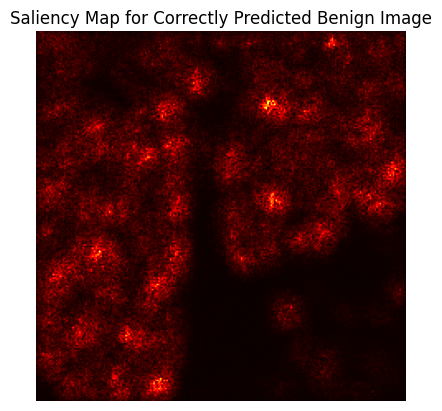

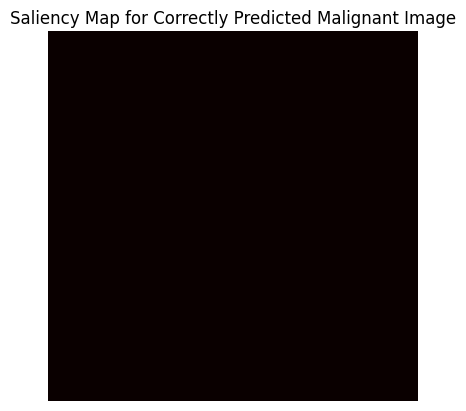

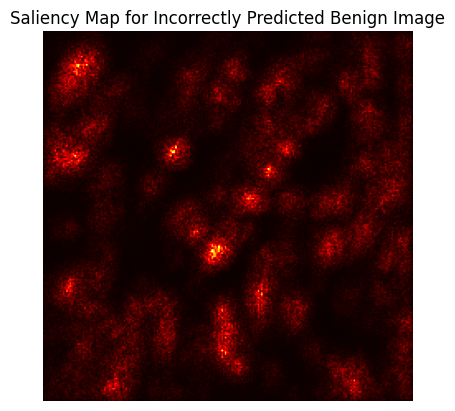

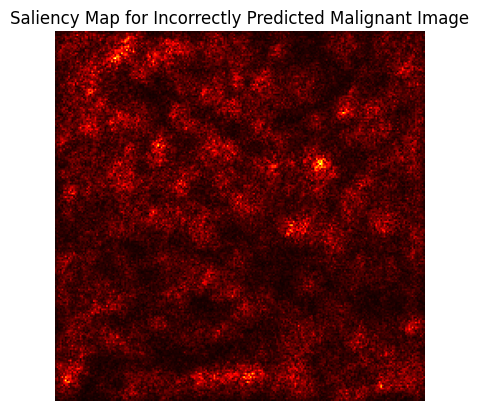

In [ ]:
# Compute saliency maps
saliency_map_correct_benign = compute_saliency_map(validation_model, sample_correct_benign_image, correct_benign_class_index)
saliency_map_correct_malignant = compute_saliency_map(validation_model, sample_correct_malignant_image, correct_malignant_class_index)
saliency_map_incorrect_benign = compute_saliency_map(validation_model, sample_incorrect_benign_image, incorrect_benign_class_index)
saliency_map_incorrect_malignant = compute_saliency_map(validation_model, sample_incorrect_malignant_image, incorrect_malignant_class_index)

def plot_saliency_map(saliency_map, title):
    plt.imshow(saliency_map, cmap='hot')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot the saliency maps
plot_saliency_map(saliency_map_correct_benign, 'Saliency Map for Correctly Predicted Benign Image')
plot_saliency_map(saliency_map_correct_malignant, 'Saliency Map for Correctly Predicted Malignant Image')
plot_saliency_map(saliency_map_incorrect_benign, 'Saliency Map for Incorrectly Predicted Benign Image')
plot_saliency_map(saliency_map_incorrect_malignant, 'Saliency Map for Incorrectly Predicted Malignant Image')
